# Simulation

In [3]:
import  fenics as fe
from dolfin import *
from mshr import *
import numpy as np


R = 0.5  # Radius of the cylinder
L = 2   #length of the cylinder

D_a = 1
A = 0.1
u_B = 1

In [15]:
constant_shift = fe.Constant(0.000001)

#Données de précision
Number_of_elemnts = 60 #définit la précision du calcul et augmente le temps de calcul
Degree_of_elements = 1 #définit la précision du calcul

# Define the geometry and mesh
cylinder = Cylinder(fe.Point(0, 0, 0), fe.Point(L, 0, 0), R, R)

mesh = generate_mesh(cylinder, Number_of_elemnts) # Generates a mesh with Number_of_elements divisions
lagrange_vector_space_first_order = fe.FunctionSpace(
        mesh,
        "Lagrange",
        Degree_of_elements,
    )
print("mesh generated")

n_trial = fe.TrialFunction(lagrange_vector_space_first_order) #guess function
v_test = fe.TestFunction(lagrange_vector_space_first_order) #test function v

#definition of the weak form of the problem
weak_form_rhs = - u_B * constant_shift * v_test * fe.ds  
weak_form_lhs = (
    fe.dot(fe.grad(n_trial), fe.grad(v_test)) * fe.dx #consequence of the IPP
    -
    u_B * n_trial * v_test * fe.ds #consequence of the boundary conditions
    -
    A * n_trial * v_test * fe.dx 
)

mesh generated
Generating mesh with CGAL 3D mesh generator


In [16]:
#solving
n_solution = fe.Function(lagrange_vector_space_first_order)
fe.solve(
    weak_form_lhs == weak_form_rhs,
    n_solution,
)
# Integral over the volume
print(fe.assemble(n_solution * fe.dx))

Solving linear variational problem.
1.536095432207796e-06


In [2]:
## ChatGPT center points fixed

In [4]:
import numpy as np
from dolfin import *

constant_shift = Constant(0.000001)

# --------------------------
# Parameters
# --------------------------
Number_of_elemnts = 60   # mesh resolution
Degree_of_elements = 1   # polynomial degree

# Geometry and mesh
cylinder = Cylinder(Point(0, 0, 0), Point(L, 0, 0), R, R)
mesh = generate_mesh(cylinder, Number_of_elemnts)
print("mesh generated")

mesh generated
Generating mesh with CGAL 3D mesh generator


In [14]:
from dolfin import *
import numpy as np

# --------------------------
# Parameters
# --------------------------
Number_of_elements = 60
Degree_of_elements = 2
L = 1.0
R = 0.1
u_B = 1.0
A = 1.0

# --------------------------
# Geometry and mesh
# --------------------------
cylinder = Cylinder(Point(0, 0, 0), Point(L, 0, 0), R, R)
mesh = generate_mesh(cylinder, Number_of_elements)

# Function space
V = FunctionSpace(mesh, "Lagrange", Degree_of_elements)

# Trial and test functions
u = TrialFunction(V)
v = TestFunction(V)

# Weak form
lhs = dot(grad(u), grad(v))*dx - u_B*u*v*ds - A*u*v*dx
rhs = -u_B*Constant(1e-6)*v*ds

# --------------------------
# SubDomain around center
# --------------------------
class Center(SubDomain):
    def inside(self, x, on_boundary):
        center = np.array([L/2.0, 0.0, 0.0])
        radius = 0.02  # adjust to include ~30 nodes
        return np.linalg.norm(x - center) < radius

center_subdomain = Center()
bc_center = DirichletBC(V, Constant(3.0), center_subdomain, "pointwise")

# --------------------------
# Assemble and solve
# --------------------------
A_sys, b_sys = assemble_system(lhs, rhs, bc_center)

n_sol = Function(V)
solve(A_sys, n_sol.vector(), b_sys)

# --------------------------
# Check solution
# --------------------------
print("Integral of solution =", assemble(n_sol*dx))

# Optional: visualize
# import matplotlib.pyplot as plt
# plot(n_sol)
# plt.show()


Generating mesh with CGAL 3D mesh generator
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Integral of solution = -0.011128843799890117


# Results analysis

center_density =  2.776625246352998


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

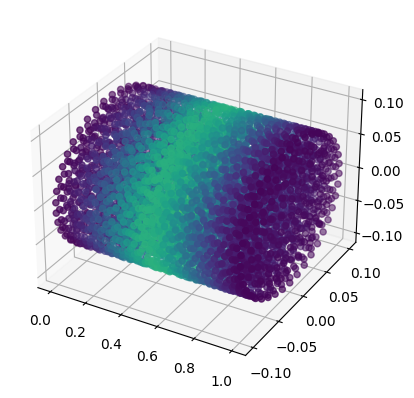

In [10]:
import matplotlib.pyplot as plt
n_solution = n_sol
print("center_density = ",  n_solution(Point(0.5, 0, 0)))
plot(n_solution)
plt.show()

Building point search tree to accelerate distance queries.
Computed bounding box tree with 57511 nodes for 28756 points.


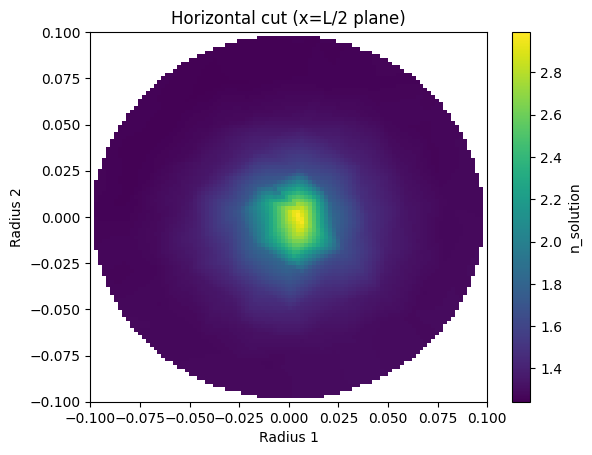

In [11]:
# Circle density
# Vertical cut through x=0 plane (y-z plane)
ny, nz = 100, 100
y = np.linspace(-R, R, ny)   # adjust to your cylinder size
z = np.linspace(-R, R, nz)
Y, Z = np.meshgrid(y, z)
X = np.zeros_like(Y) + L/2

values = np.zeros_like(Y)
for i in range(ny):
    for j in range(nz):
        try:
            values[j, i] = n_solution(Point(X[j,i], Y[j,i], Z[j,i]))
        except RuntimeError:   # point outside domain
            values[j, i] = np.nan

plt.figure()
plt.imshow(values, extent=[y.min(), y.max(), z.min(), z.max()],
           origin="lower", aspect="auto")
plt.colorbar(label="n_solution")
plt.xlabel("Radius 1")
plt.ylabel("Radius 2")
plt.title("Horizontal cut (x=L/2 plane)")
plt.show()


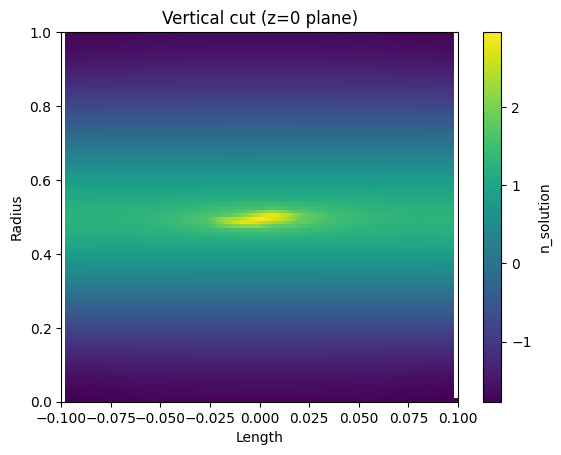

In [12]:
# Vertical cut through z=0 plane
ny, nz = 100, 100
y = np.linspace(-R, R, ny)   # adjust to your cylinder size
z = np.linspace(0, L, nz)
Y, Z = np.meshgrid(y, z)
X = np.zeros_like(Y)

values = np.zeros_like(Y)
for j in range(nz):
    for i in range(ny):
        try:
            values[j, i] = n_solution(Point(Z[j,i], Y[j,i], X[j,i]))
        except RuntimeError:   # point outside domain
            values[j, i] = np.nan

plt.figure()
plt.imshow(values, extent=[y.min(), y.max(), z.min(), z.max()],
           origin="lower", aspect="auto")
plt.colorbar(label="n_solution")
plt.xlabel("Length")
plt.ylabel("Radius")
plt.title("Vertical cut (z=0 plane)")
plt.show()


center_density =  2.776625246352998


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

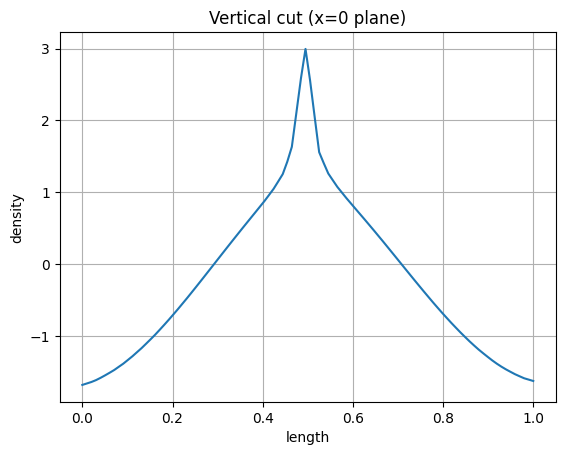

In [13]:
print("center_density = ",  n_solution(Point(L/2, 0, 0)))
ny, nz = 100, 100
y =0   # adjust to your cylinder size
z = np.linspace(0, L, nz)


values = []
for i in range(nz):
        try:
            values.append(n_solution(Point(z[i], 0, 0)))
        except RuntimeError:   # point outside domain
            values.append(np.nan)

plt.figure()
plt.plot(z, values)
plt.xlabel("length")
plt.ylabel("density")
plt.title("Vertical cut (x=0 plane)")
plt.grid()
plt.show()

center_density =  9.96655895252792e-07


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

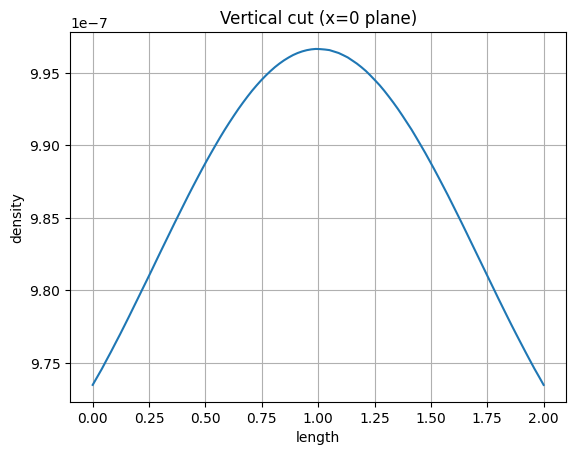

In [19]:
print("center_density = ",  n_solution(Point(L/2, 0, 0)))
ny, nz = 100, 100
y =0   # adjust to your cylinder size
z = np.linspace(0, L, nz)


values = []
for i in range(nz):
        try:
            values.append(n_solution(Point(z[i], 0, 0)))
        except RuntimeError:   # point outside domain
            values.append(np.nan)

plt.figure()
plt.plot(z, values)
plt.xlabel("length")
plt.ylabel("density")
plt.title("Vertical cut (x=0 plane)")
plt.grid()
plt.show()